# Predicting regional COVID-19 hospital admissions in Sweden using mobility data
This notebook accompanies the manuscript "Predicting regional COVID-19 hospital admissions in Sweden using mobility data" and contains code for generain. To run it requires the following files: "statistik-covid19-inskrivna.xlsx", "VT.xlsx","ST.xlsx" and "param_IC.pkl".

Questions and comments: gerlee@chalmers.se

In [190]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

In [191]:
#Parameters
n=20
startvecka=10-4 #start week
Tmax=48 #length of prediction
pv=0.023 #fraction of infected that are admitted

rho=7*1/5.1 #latency period
gamma=7*1/5 #recovery rate

delay=3#2.5 #delay from infection to admission

In [34]:
'''#Load data from Västtrafik
df = pandas.read_excel('VT.xlsx') #read excel-file
values = df['Unnamed: 4'].values 
diff = np.array(values[4:]) 
diff=np.insert(diff,0,[0.2,0.2]) #Set baseline travel
T=np.arange(7,7+len(diff),1)
resfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function
'''

'#Load data from Västtrafik\ndf = pandas.read_excel(\'VT.xlsx\') #read excel-file\nvalues = df[\'Unnamed: 4\'].values \ndiff = np.array(values[4:]) \ndiff=np.insert(diff,0,[0.2,0.2]) #Set baseline travel\nT=np.arange(7,7+len(diff),1)\nresfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function\n'

In [192]:
df = pandas.read_csv('../data/2020_SE_Region_Mobility_Report.csv')
df

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,SE,Sweden,NaN,NaN,NaN,NaN,NaN,2020-02-15,2.0,0.0,3.0,4.0,-2.0,0.0
1,SE,Sweden,NaN,NaN,NaN,NaN,NaN,2020-02-16,-10.0,-7.0,-30.0,-11.0,-5.0,2.0
2,SE,Sweden,NaN,NaN,NaN,NaN,NaN,2020-02-17,-4.0,-3.0,-3.0,-6.0,-6.0,2.0
3,SE,Sweden,NaN,NaN,NaN,NaN,NaN,2020-02-18,0.0,0.0,13.0,-4.0,-5.0,1.0
4,SE,Sweden,NaN,NaN,NaN,NaN,NaN,2020-02-19,3.0,1.0,26.0,-3.0,-5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62820,SE,Sweden,Västra Götaland County,Vårgårda Municipality,NaN,NaN,NaN,2020-11-16,NaN,NaN,NaN,-44.0,-11.0,NaN
62821,SE,Sweden,Västra Götaland County,Vårgårda Municipality,NaN,NaN,NaN,2020-11-17,NaN,NaN,NaN,-41.0,-13.0,NaN
62822,SE,Sweden,Västra Götaland County,Vårgårda Municipality,NaN,NaN,NaN,2020-11-18,NaN,NaN,NaN,-43.0,-19.0,NaN
62823,SE,Sweden,Västra Götaland County,Vårgårda Municipality,NaN,NaN,NaN,2020-11-19,NaN,NaN,NaN,-51.0,-19.0,NaN


In [193]:
temp2=df.loc[df['iso_3166_2_code']=='SE-O']
temp2

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
52834,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-02-15,-3.0,-1.0,13.0,1.0,-4.0,0.0
52835,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-02-16,-17.0,-11.0,-58.0,-20.0,-8.0,2.0
52836,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-02-17,-6.0,-4.0,-26.0,-6.0,-1.0,1.0
52837,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-02-18,0.0,1.0,14.0,-2.0,0.0,1.0
52838,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-02-19,5.0,3.0,34.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53111,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-11-18,-26.0,-5.0,-1.0,-44.0,-25.0,11.0
53112,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-11-19,-25.0,-4.0,-1.0,-44.0,-25.0,12.0
53113,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-11-20,-21.0,-3.0,38.0,-39.0,-26.0,11.0
53114,SE,Sweden,Västra Götaland County,NaN,NaN,SE-O,NaN,2020-11-21,-34.0,-10.0,-21.0,-49.0,-12.0,9.0


In [194]:
transit=temp2['transit_stations_percent_change_from_baseline'].values 
transit

array([  1., -20.,  -6.,  -2.,   1.,  -5.,   1.,  -4.,  -6.,   3.,   1.,
        -2.,   3.,   3.,   4.,  -9.,  -2.,  -2.,  -5.,  -3.,  -1.,   6.,
       -15.,  -5.,  -6.,  -8., -17., -21., -12., -38., -23., -30., -36.,
       -35., -34., -23., -31., -37., -36., -36., -33., -32., -27., -34.,
       -35., -35., -37., -43., -37., -32., -32., -31., -33., -36., -33.,
       -49., -41., -45., -57., -35., -37., -33., -32., -21., -25., -28.,
       -25., -28., -30., -32., -18., -31., -39., -34., -33., -35., -56.,
       -27., -24., -34., -30., -30., -28., -30., -11., -42., -31., -33.,
       -30., -32., -32., -26., -35., -29., -27., -20., -36., -34., -24.,
       -39., -25., -21., -26., -22., -19.,   1.,  -9., -18., -18., -22.,
       -23., -31., -21., -19., -21., -20., -20., -21., -22.,  -1.,  -7.,
       -18., -19., -20., -15., -41., -26., -32., -29., -19., -20., -17.,
       -18.,   1., -25., -24., -30., -26., -24., -27., -18., -34., -36.,
       -30., -26., -26., -27.,  -4., -12., -27., -3

In [201]:
dagar=np.arange(46,46+len(transit)) # from 46 days to 327 days
dagar

array([ 46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 22

In [202]:
tv=np.ceil(dagar/7)
tv

array([ 7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,
        9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 11.,
       11., 11., 11., 11., 11., 11., 12., 12., 12., 12., 12., 12., 12.,
       13., 13., 13., 13., 13., 13., 13., 14., 14., 14., 14., 14., 14.,
       14., 15., 15., 15., 15., 15., 15., 15., 16., 16., 16., 16., 16.,
       16., 16., 17., 17., 17., 17., 17., 17., 17., 18., 18., 18., 18.,
       18., 18., 18., 19., 19., 19., 19., 19., 19., 19., 20., 20., 20.,
       20., 20., 20., 20., 21., 21., 21., 21., 21., 21., 21., 22., 22.,
       22., 22., 22., 22., 22., 23., 23., 23., 23., 23., 23., 23., 24.,
       24., 24., 24., 24., 24., 24., 25., 25., 25., 25., 25., 25., 25.,
       26., 26., 26., 26., 26., 26., 26., 27., 27., 27., 27., 27., 27.,
       27., 28., 28., 28., 28., 28., 28., 28., 29., 29., 29., 29., 29.,
       29., 29., 30., 30., 30., 30., 30., 30., 30., 31., 31., 31., 31.,
       31., 31., 31., 32., 32., 32., 32., 32., 32., 32., 33., 33

In [203]:
gveckor = np.unique(tv)
gveckor

array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
       33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45.,
       46., 47.])

In [204]:
len(gveckor)

41

In [205]:
int(max(gveckor)-min(gveckor))+1  # number of weeks

41

In [206]:
Tr = np.zeros(int(max(gveckor)-min(gveckor))+1)
print(len(Tr))
Tr

41


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [207]:
print(len(tv))
print(tv)
print(len(gveckor))
print(gveckor)
print(len(Tr))
print(Tr)

282
[ 7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.
 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 12. 12. 12. 12.
 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 14. 14. 15.
 15. 15. 15. 15. 15. 15. 16. 16. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17.
 17. 17. 18. 18. 18. 18. 18. 18. 18. 19. 19. 19. 19. 19. 19. 19. 20. 20.
 20. 20. 20. 20. 20. 21. 21. 21. 21. 21. 21. 21. 22. 22. 22. 22. 22. 22.
 22. 23. 23. 23. 23. 23. 23. 23. 24. 24. 24. 24. 24. 24. 24. 25. 25. 25.
 25. 25. 25. 25. 26. 26. 26. 26. 26. 26. 26. 27. 27. 27. 27. 27. 27. 27.
 28. 28. 28. 28. 28. 28. 28. 29. 29. 29. 29. 29. 29. 29. 30. 30. 30. 30.
 30. 30. 30. 31. 31. 31. 31. 31. 31. 31. 32. 32. 32. 32. 32. 32. 32. 33.
 33. 33. 33. 33. 33. 33. 34. 34. 34. 34. 34. 34. 34. 35. 35. 35. 35. 35.
 35. 35. 36. 36. 36. 36. 36. 36. 36. 37. 37. 37. 37. 37. 37. 37. 38. 38.
 38. 38. 38. 38. 38. 39. 39. 39. 39. 39. 39. 39. 40. 40. 40. 40. 40. 40.
 40. 41. 41. 41. 41. 41. 41. 41. 42. 42. 42. 42

In [208]:
# Calculating weekly averages
k=0
for i in gveckor:
    ind=tv==i
    print(i)
    #print(ind)
    
    Tr[k]=np.mean(transit[ind])/100
    k=k+1
    #print(Tr)
    init=0.2 #0.1 innan
    Tr[0:2]=[init,init]
    #print(Tr) 
    Trfkn_vgr = interp1d(gveckor-startvecka,Tr,kind="linear",fill_value="extrapolate") #create function

7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0


In [209]:
gveckor-startvecka

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41.])

In [212]:
Tr

array([ 0.2       ,  0.2       , -0.00714286, -0.04142857, -0.21285714,
       -0.33142857, -0.33142857, -0.35      , -0.42285714, -0.28714286,
       -0.30285714, -0.34142857, -0.29285714, -0.30142857, -0.28428571,
       -0.15857143, -0.22428571, -0.15428571, -0.26      , -0.19      ,
       -0.27857143, -0.23      , -0.21857143, -0.23      , -0.20571429,
       -0.16714286, -0.14571429, -0.21428571, -0.19428571, -0.22714286,
       -0.24142857, -0.21571429, -0.23857143, -0.25285714, -0.26142857,
       -0.26      , -0.28142857, -0.32571429, -0.36428571, -0.4       ,
       -0.446     ])

In [58]:
#Load data from Google
df = pandas.read_csv('../data/2020_SE_Region_Mobility_Report.csv') #read excel-file
temp2=df.loc[df['iso_3166_2_code']=='SE-O']
transit=temp2['transit_stations_percent_change_from_baseline'].values 
dagar=np.arange(46,46+len(transit)) #create array of days corresponding to google data

tv=np.ceil(dagar/7)
gveckor=np.unique(tv)

Tr=np.zeros(int(max(gveckor)-min(gveckor))+1)



In [59]:
#time-dependent infectivity
def beta(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

In [110]:
dx

<function __main__.dx(x, t, a, b, lag)>

In [213]:
file = pandas.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
data = [['Sthlm', 8,2389923], ['VGR', 9,1725881], ['Skåne', 10,1387650],['Östergötland',11,467095],['Jönköping',12,364750],['Södermanland',13,299101],['Uppsala',14,387628],['Gävleborg',15,287660],['Västmanland',16,277074],['Örebro',17,305726],['Norrbotten',18,249768],['Dalarna',19,287806],['Västernorrland',20,244855],['Värmland',21,282840],['Halland',22,336132],['Kalmar',23,245992],['Kronoberg',24,202163],['Västerbotten',25,273061],['Jämtland',26,130972],['Blekinge',27,159349],['Gotland',28,60106]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index','population']) 
regionkod=['SE-AB','SE-O','SE-M','SE-E','SE-F','SE-D','SE-C','SE-X','SE-U','SE-T','SE-BD','SE-W','SE-Y','SE-S','SE-N','SE-H','SE-G','SE-AC','SE-Z','SE-K','SE-I']
regioner['Regionkod'] = regionkod

In [214]:
regioner

,region,index,population,Regionkod
0,Sthlm,8,2389923,SE-AB
1,VGR,9,1725881,SE-O
2,Skåne,10,1387650,SE-M
3,Östergötland,11,467095,SE-E
4,Jönköping,12,364750,SE-F
5,Södermanland,13,299101,SE-D
6,Uppsala,14,387628,SE-C
7,Gävleborg,15,287660,SE-X
8,Västmanland,16,277074,SE-U
9,Örebro,17,305726,SE-T


In [215]:
yta=np.array([6524,23800,10968,10559,8190,10437,5427,8504,6075,28029,18118,17519,5118,54665,97239,11165,21549,8424,2931,48935,3135]) #area of region
regioner['Area']=yta

In [216]:
regioner

,region,index,population,Regionkod,Area
0,Sthlm,8,2389923,SE-AB,6524
1,VGR,9,1725881,SE-O,23800
2,Skåne,10,1387650,SE-M,10968
3,Östergötland,11,467095,SE-E,10559
4,Jönköping,12,364750,SE-F,8190
5,Södermanland,13,299101,SE-D,10437
6,Uppsala,14,387628,SE-C,5427
7,Gävleborg,15,287660,SE-X,8504
8,Västmanland,16,277074,SE-U,6075
9,Örebro,17,305726,SE-T,28029


In [217]:
ffall = 9*np.ones(21).astype(int) #week number when first case was recorded
regioner['Första fall'] = ffall
regioner

,region,index,population,Regionkod,Area,Första fall
0,Sthlm,8,2389923,SE-AB,6524,9
1,VGR,9,1725881,SE-O,23800,9
2,Skåne,10,1387650,SE-M,10968,9
3,Östergötland,11,467095,SE-E,10559,9
4,Jönköping,12,364750,SE-F,8190,9
5,Södermanland,13,299101,SE-D,10437,9
6,Uppsala,14,387628,SE-C,5427,9
7,Gävleborg,15,287660,SE-X,8504,9
8,Västmanland,16,277074,SE-U,6075,9
9,Örebro,17,305726,SE-T,28029,9


In [218]:
startvecka = ffall - 3
print(startvecka)
regioner.drop(regioner.index[[20]],inplace=True) #remove Gotland
print(regioner)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
            region  index  population Regionkod   Area  Första fall
0            Sthlm      8     2389923     SE-AB   6524            9
1              VGR      9     1725881      SE-O  23800            9
2            Skåne     10     1387650      SE-M  10968            9
3     Östergötland     11      467095      SE-E  10559            9
4        Jönköping     12      364750      SE-F   8190            9
5     Södermanland     13      299101      SE-D  10437            9
6          Uppsala     14      387628      SE-C   5427            9
7        Gävleborg     15      287660      SE-X   8504            9
8      Västmanland     16      277074      SE-U   6075            9
9           Örebro     17      305726      SE-T  28029            9
10      Norrbotten     18      249768     SE-BD  18118            9
11         Dalarna     19      287806      SE-W  17519            9
12  Västernorrland     20      244855      SE-Y   5118            9
13  

In [234]:
file

,"Nyinskrivna i slutenvård med covid-19, antal patienter per inskrivningsvecka och region",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,Antal unika patienter som rapporterats till So...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Totalt antal inskrivna patienter,NaN,Månadsrapportering till patientregistret,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,vecka 10,NaN,vecka 11,NaN,vecka 12,NaN,vecka 13,...,vecka 48,NaN,vecka 49,NaN,vecka 50,NaN,vecka 51,NaN,vecka 52,NaN
5,NaN,Antal,%*,Antal,%**,Antal,%**,Antal,%**,Antal,...,Antal,%**,Antal,%**,Antal,%**,Antal,%**,Antal,%**
6,Totalt inrapporterat,35057,100,63,0.179707,169,0.482072,639,1.822746,1465,...,1667,4.755113,1568,4.472716,1608,4.586816,1251,3.568474,365,1.041162
7,Rapporterande region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Stockholm,13035,37.182303,37,0.283851,83,0.636747,335,2.570004,734,...,632,4.848485,548,4.204066,521,3.996931,347,2.662064,43,0.329881
9,Västra Götaland,5293,15.098269,9,0.170036,18,0.340072,56,1.058001,94,...,205,3.87304,259,4.893255,323,6.102399,328,6.196864,202,3.816361


In [220]:
regs = pandas.read_pickle('../data/param_IC.pkl')
regs

,region,index,population,Regionkod,a,b,E
0,Sthlm,8,2389923,SE-AB,4.759494,9.215190,175.235300
1,VGR,9,1725881,SE-O,3.848101,9.493671,90.821751
2,Skåne,10,1387650,SE-M,3.620253,8.240506,41.357155
3,Östergötland,11,467095,SE-E,3.734177,8.379747,17.383155
4,Jönköping,12,364750,SE-F,3.278481,10.050633,21.330193
5,Södermanland,13,299101,SE-D,3.734177,9.215190,15.531288
6,Uppsala,14,387628,SE-C,3.506329,6.430380,17.883654
7,Gävleborg,15,287660,SE-X,3.164557,10.746835,20.700678
8,Västmanland,16,277074,SE-U,3.506329,6.848101,8.616789
9,Örebro,17,305726,SE-T,3.392405,8.379747,12.290108


In [ ]:
namn = regioner['region'].values
t = np.linspace(0,Tmax,200)

 #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

A=np.array([])
B=np.array([])
E=np.array([])



In [221]:
namn

array(['Sthlm', 'VGR', 'Skåne', 'Östergötland', 'Jönköping',
       'Södermanland', 'Uppsala', 'Gävleborg', 'Västmanland', 'Örebro',
       'Norrbotten', 'Dalarna', 'Västernorrland', 'Värmland', 'Halland',
       'Kalmar', 'Kronoberg', 'Västerbotten', 'Jämtland', 'Blekinge'],
      dtype=object)

In [222]:
ffall

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [272]:
def getData(namn,ffall):
    temp=regioner.loc[regioner['region']==namn] #find the right row
    index=temp['index'].values #find the region index
    N=temp['population'].values #find population size of region

    R = file.iloc[index[0]] 
    R=R.replace(' ','X') #replace missing data with 0
    R=R.replace('X',0) 
    R=R.replace('IU',0) 
    
    ind = np.arange(3,len(R),2) 
    I = R.iloc[ind].values #extract admissions
    print(I)
    print(len(I))
    I=I[:-2] #remove last (incomplete) data point
    print(I)
    padding = np.zeros(10-ffall+3) 
    I=np.insert(I,0,padding) 
    print(I)
    veckor = np.arange(0,len(I),1) #create array of week numbers
    print(veckor)
    
    return I,veckor,N
from scipy.interpolate import interp1d

#Load Google mobility data
def loadMobility(namn,svecka):
    df = pandas.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp=regioner.loc[regioner['region']==namn] 
    kod=temp['Regionkod'].values 
    temp2=df.loc[df['iso_3166_2_code']==kod[0]]
    transit=temp2['transit_stations_percent_change_from_baseline'].values 
    dagar=np.arange(46,46+len(transit))
    tv=np.ceil(dagar/7)
    
    
    gveckor=np.unique(tv)
    k=0
    Tr=np.zeros(int(max(gveckor)-min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    print(gveckor)
    print(gveckor-svecka)
    Trfkn = interp1d(gveckor-svecka,Tr,kind="linear",fill_value="extrapolate")
    print(Tr)
    return Trfkn

In [273]:
#Loop over regions
k=0
for R in namn:
    print(R)
    I,veckor,N = getData(R,ffall[k])
    transit_fkn=loadMobility(R,startvecka[k])
    break

Sthlm
[37 83 335 734 968 984 872 739 567 548 448 394 440 364 292 220 171 111 82
 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531 592 632 548 521
 347 43]
43
[37 83 335 734 968 984 872 739 567 548 448 394 440 364 292 220 171 111 82
 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531 592 632 548 521]
[0.0 0.0 0.0 0.0 37 83 335 734 968 984 872 739 567 548 448 394 440 364 292
 220 171 111 82 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531
 592 632 548 521]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.
 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42.
 43. 44. 45. 46. 47.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41.]
[ 0.2         0.2        -0.05857143 -0.03

In [347]:
def beta(t,a,b,transit_fkn):
    return a+b*transit_fkn(t)

def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b,transit_fkn)*x3/N
    dx2 = x1*beta(t-lag,a,b,transit_fkn)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    m = [dx1, dx2, dx3, dx4]
    m = [np.float64(x[0] if isinstance(i, np.ndarray) else i) for i in m]
    return m

#define output from model
def pred_inlagda(t,a,b,lag):
    x0 = [N-1,0,1,0] #initial conditions
    x0 = [x0[0][0]] + x0[1:]
    print(x0,t,a,b )

    x = odeint(dx, x0, t,args=(a,b,lag))
    #x = [np.float64(x[0] if isinstance(i, np.ndarray) else i) for i in x]
    print(x)
    return pv*x[:,2]

array(['Sthlm', 'VGR', 'Skåne', 'Östergötland', 'Jönköping',
       'Södermanland', 'Uppsala', 'Gävleborg', 'Västmanland', 'Örebro',
       'Norrbotten', 'Dalarna', 'Västernorrland', 'Värmland', 'Halland',
       'Kalmar', 'Kronoberg', 'Västerbotten', 'Jämtland', 'Blekinge'],
      dtype=object)

In [349]:
I

array([0.0, 0.0, 0.0, 0.0, 37, 83, 335, 734, 968, 984, 872, 739, 567, 548,
       448, 394, 440, 364, 292, 220, 171, 111, 82, 57, 52, 41, 47, 38, 28,
       23, 29, 30, 31, 31, 57, 88, 78, 131, 262, 399, 531, 592, 632, 548,
       521], dtype=object)

In [350]:
veckor

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [351]:
R = 'Sthlm'
k = 0
#I,veckor,N = getData(R,ffall[k])
#transit_fkn=loadMobility(R,startvecka[k])

I_train=I
veckor_train=veckor
n=10
ah=np.linspace(3,5,n)
bh=np.linspace(4,6,n)

E=np.zeros((len(ah),len(bh)))
for i in range(n):
    print(i)
    for j in range(n):
        P=pred_inlagda(veckor_train,ah[i],bh[j],delay)
        E[i,j]=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))

0
[2389922, 0, 1, 0] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] 3.0 4.0
[[2.38992200e+06 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.49648154e+06 4.10655954e+06 1.61299407e+06 7.43176112e+05]
 [1.76592678e+07 1.52693458e+07 7.81556109e+06 6.58179529e+06]
 [4.80028669e+07 4.56129449e+07 2.51241990e+07 2.76409495e+07]
 [1.30485322e+08 1.28095400e+08 7.22845082e+07 9.04115686e+07]
 [3.54695885e+08 3.52305963e+08 2.00506783e+08 2.66648997e+08]
 [9.64163391e+08 9.61773469e+08 5.49057791e+08 7.51341732e+08]
 [2.62086786e+09 2.61847794e+09 1.49651933e+09 2.07450800e+09]
 [7.12425757e+09 7.12186764e+09 4.07198726e+09 5.67688291e+09]
 [1.93657401e+10 1.93633502e+10 1.10728351e+10 1.54747897e+10]
 [5.26415402e+10 5.26391502e+10 3.01031129e+10 4.21138983e+10]
 [1.43094544e+11 1.43092154e+11 8.18327718e+10 1.14532141e+11]
 [3.88971303e+11 3.88968913e+11 2.22448566e+11 3.11390972e+11]
 [1.05733364e+

In [369]:
#fit model to data

#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b,transit_fkn)*x3/N
    dx2 = x1*beta(t-lag,a,b,transit_fkn)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    m = [dx1, dx2, dx3, dx4]
    m = [np.float64(x[0] if isinstance(i, np.ndarray) else i) for i in m]

    return m

#define output from model
def pred_inlagda(t,a,b,lag):
    x0 = [N-1,0,1,0] #initial conditions
    x0 = [x0[0][0]] + x0[1:]
    x = odeint(dx, x0, t,args=(a,b,lag))
    
    return pv*x[:,2]
    
def fitModel(veckor,I,astart_,bstart_,lag):
    print(pred_inlagda, I,veckor, (astart, bstart))
    fit, cov = curve_fit(pred_inlagda,veckor,I,bounds=([1,1,3-0.001],[12, 12,3+0.001]),p0=(astart_,bstart_,lag))
    P=pred_inlagda(veckor,fit[0],fit[1],lag)
    E=np.sqrt(np.sum((P-I)**2)/len(I))/np.amax(I)
    return fit[0],fit[1],E

In [370]:
I

array([0.0, 0.0, 0.0, 0.0, 37, 83, 335, 734, 968, 984, 872, 739, 567, 548,
       448, 394, 440, 364, 292, 220, 171, 111, 82, 57, 52, 41, 47, 38, 28,
       23, 29, 30, 31, 31, 57, 88, 78, 131, 262, 399, 531, 592, 632, 548,
       521], dtype=object)

In [371]:
veckor

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [372]:
astart

array([4.75949367, 3.84810127, 3.62025316, 3.73417722, 3.27848101,
       3.73417722, 3.50632911, 3.16455696, 3.50632911, 3.39240506,
       3.05063291, 2.93670886, 2.93670886, 2.70886076, 2.59493671,
       2.36708861, 2.93670886, 2.93670886, 2.82278481, 1.6835443 ])

Sthlm
[37 83 335 734 968 984 872 739 567 548 448 394 440 364 292 220 171 111 82
 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531 592 632 548 521
 347 43]
43
[37 83 335 734 968 984 872 739 567 548 448 394 440 364 292 220 171 111 82
 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531 592 632 548 521]
[0.0 0.0 0.0 0.0 37 83 335 734 968 984 872 739 567 548 448 394 440 364 292
 220 171 111 82 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531
 592 632 548 521]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.
 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42.
 43. 44. 45. 46. 47.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41.]
[ 0.2         0.2        -0.05857143 -0.03

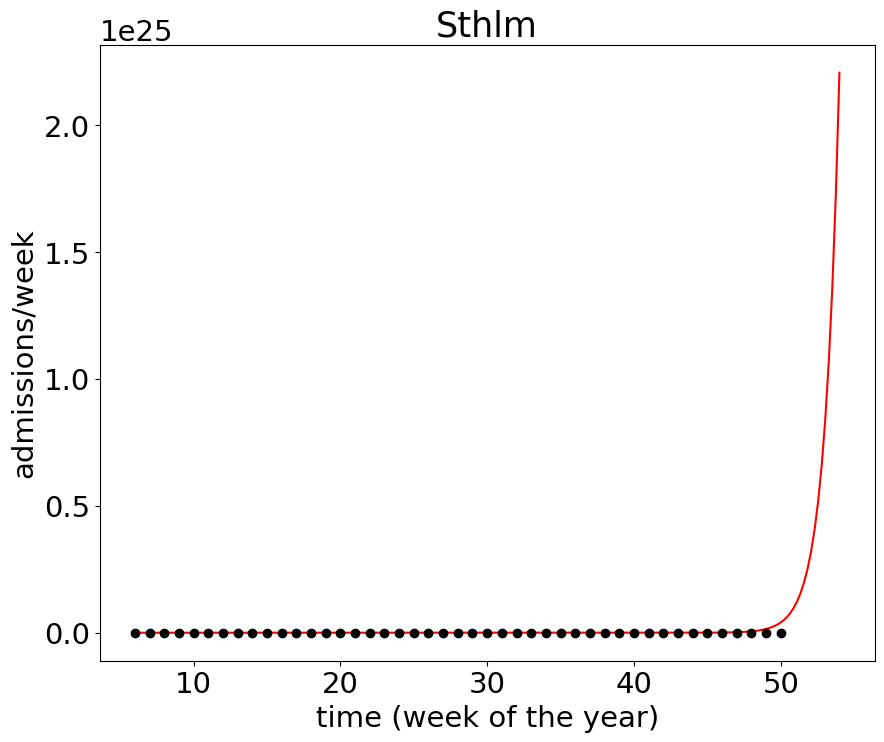

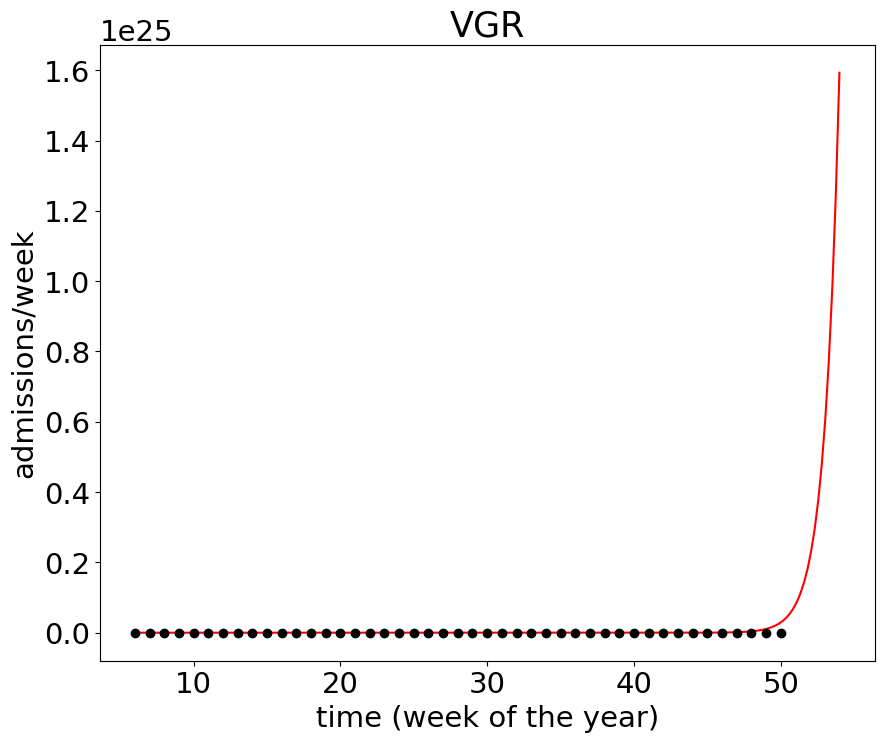

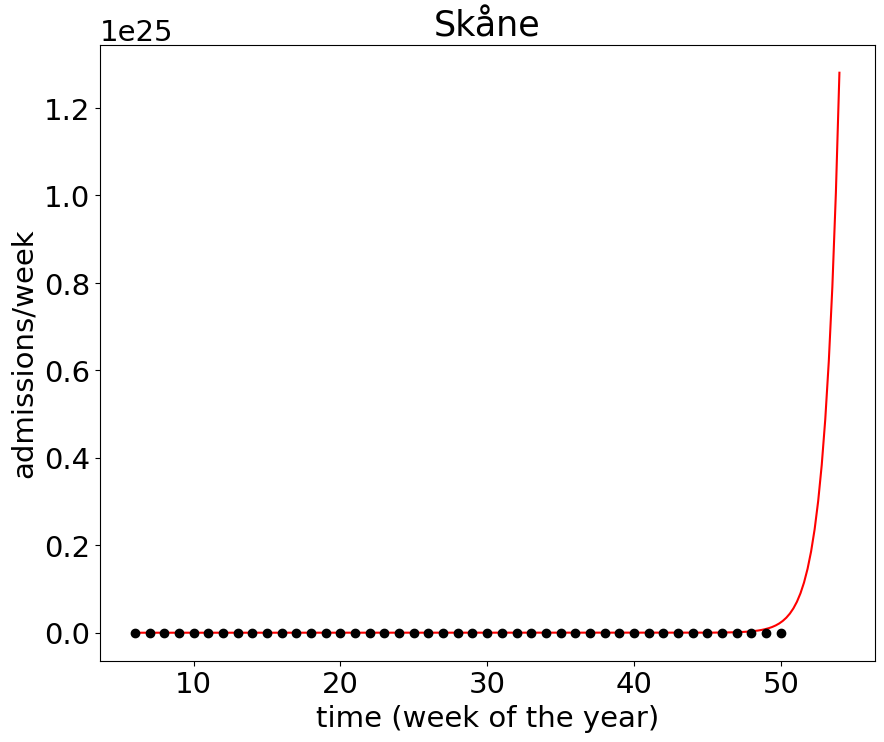

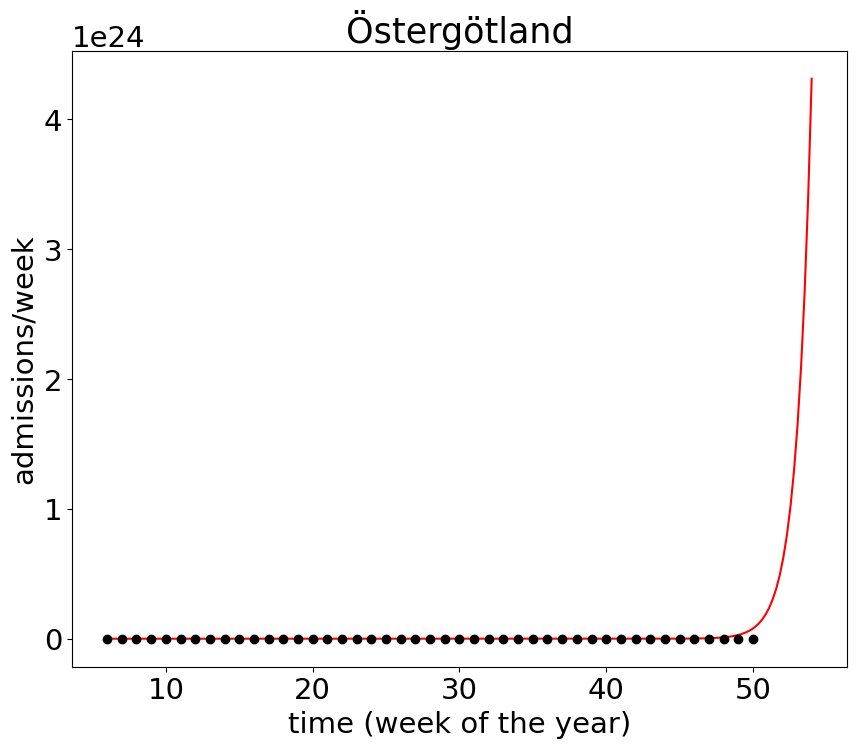

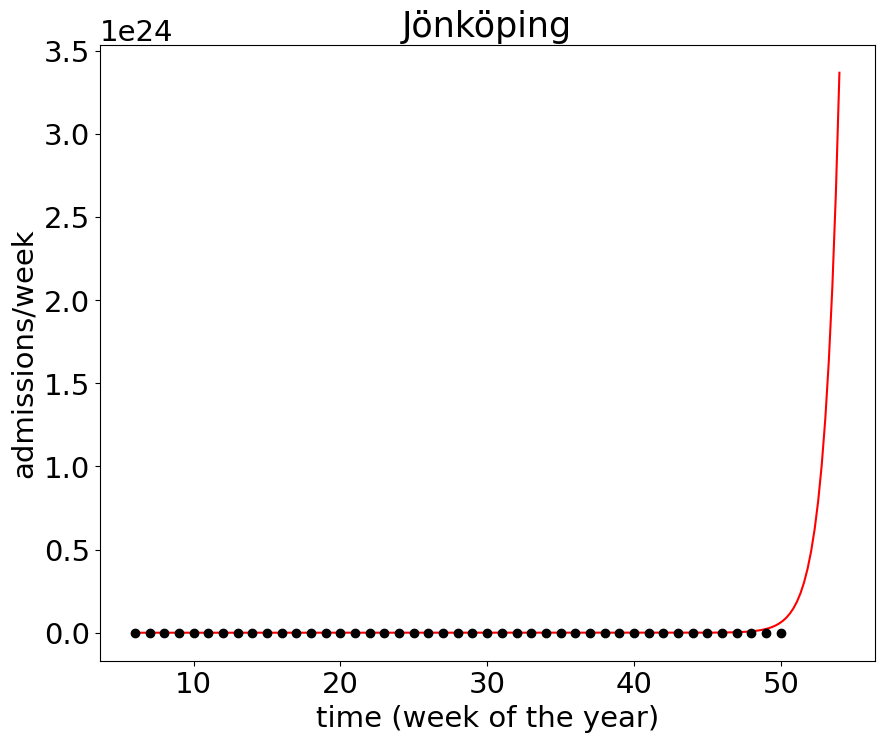

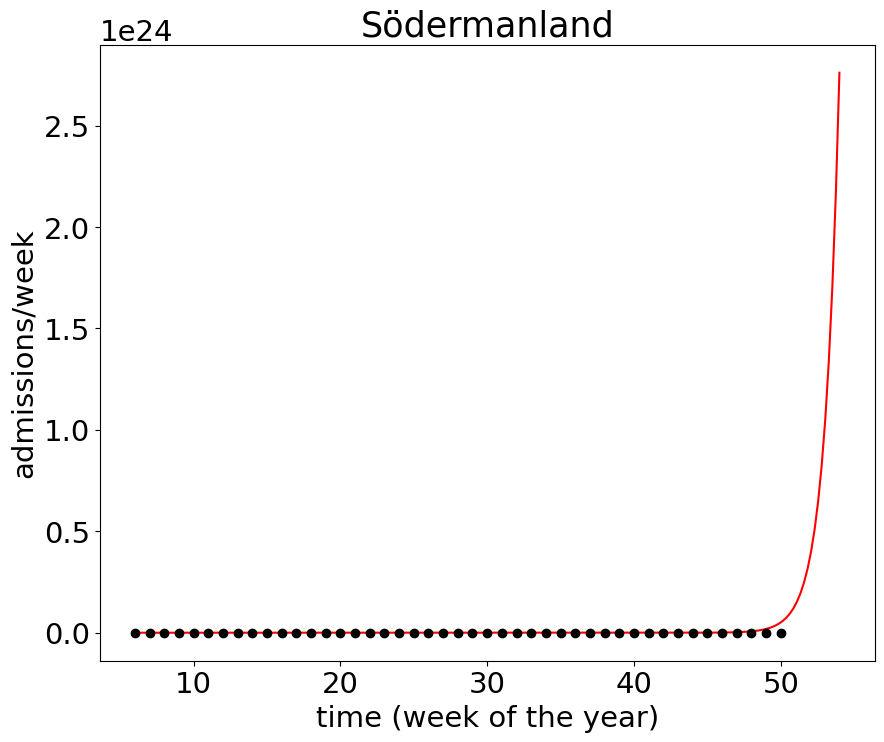

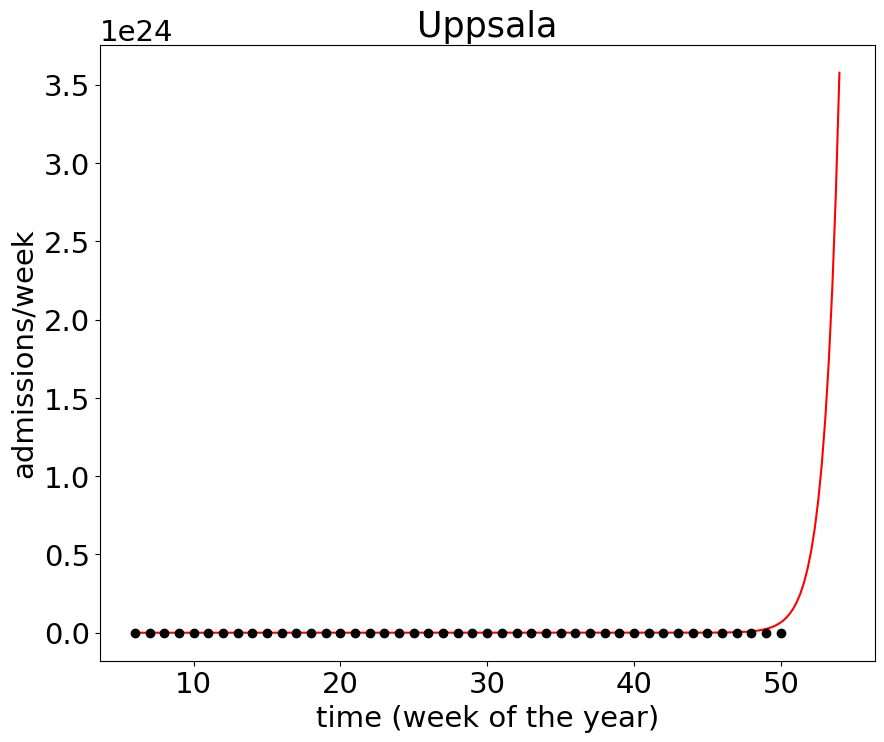

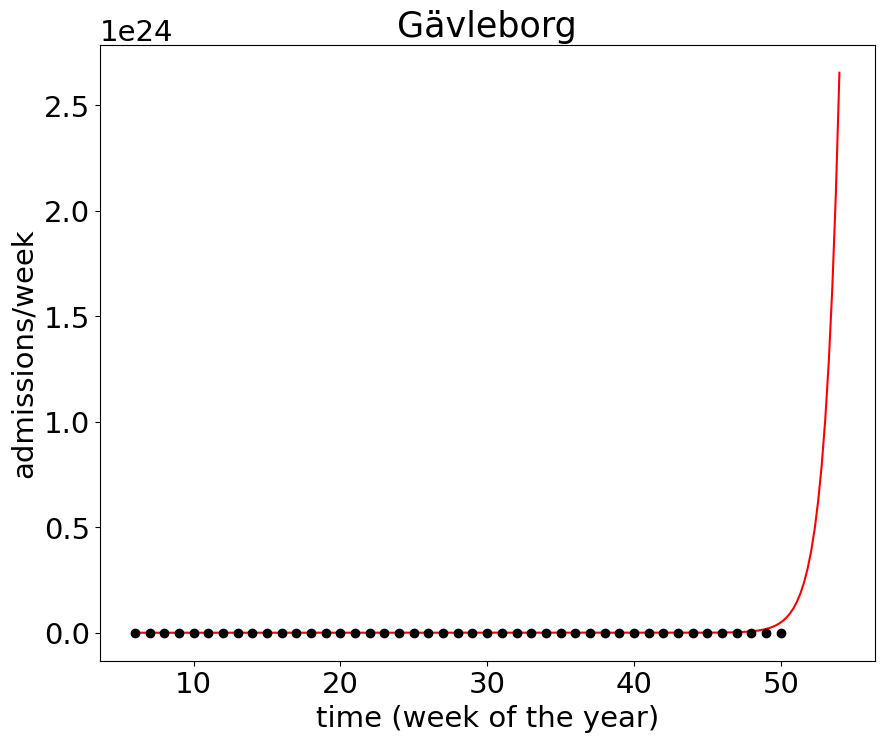

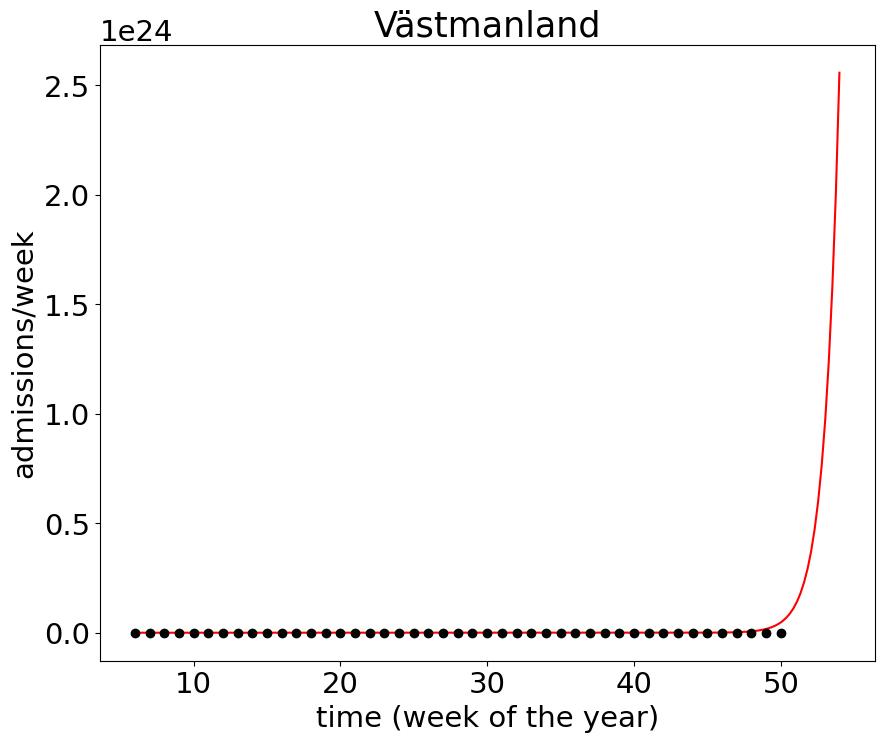

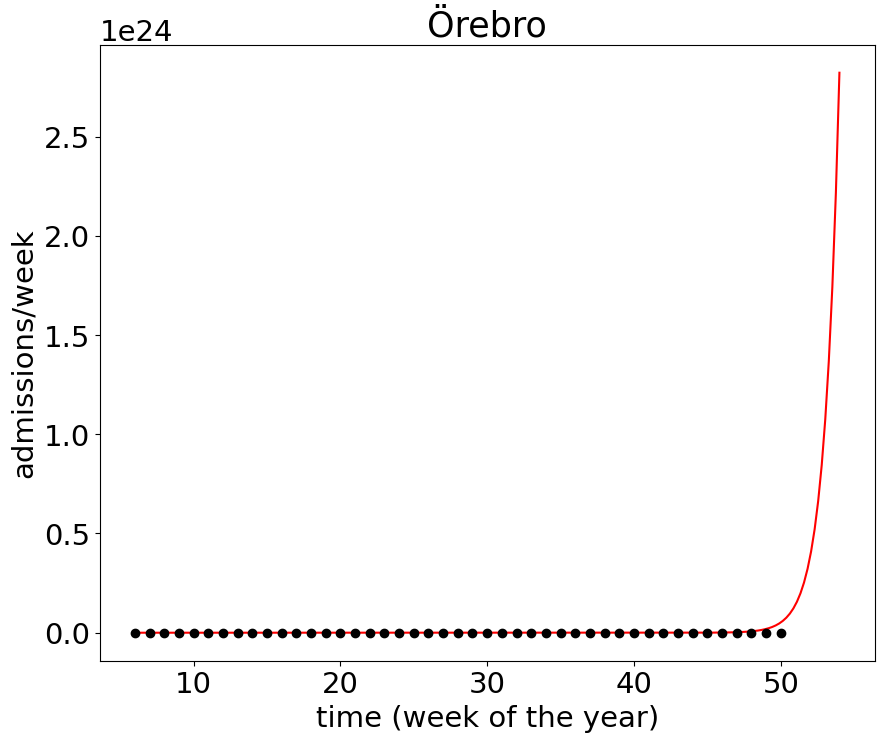

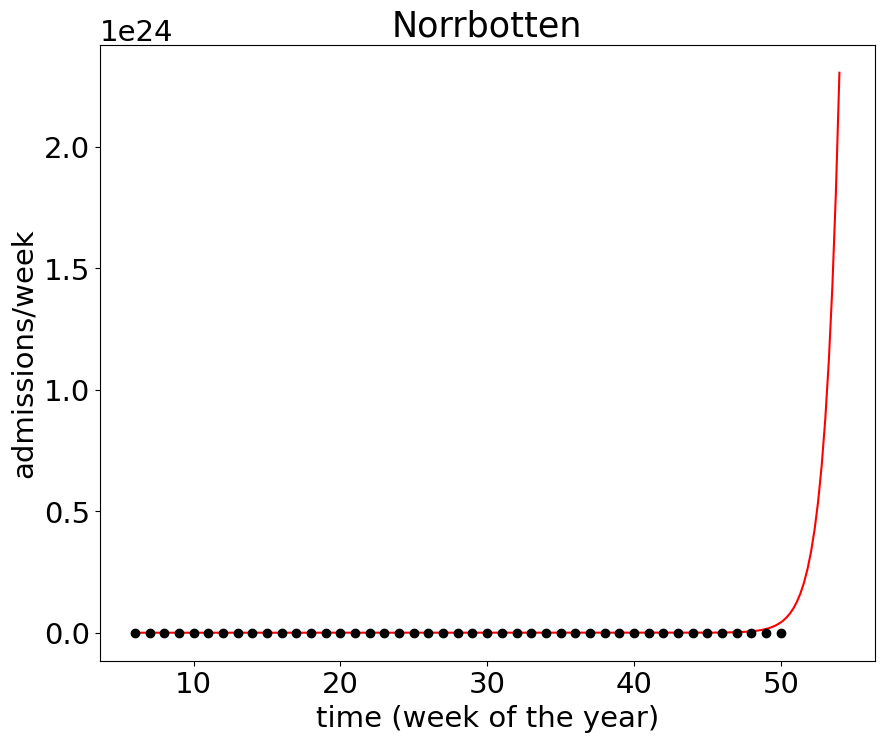

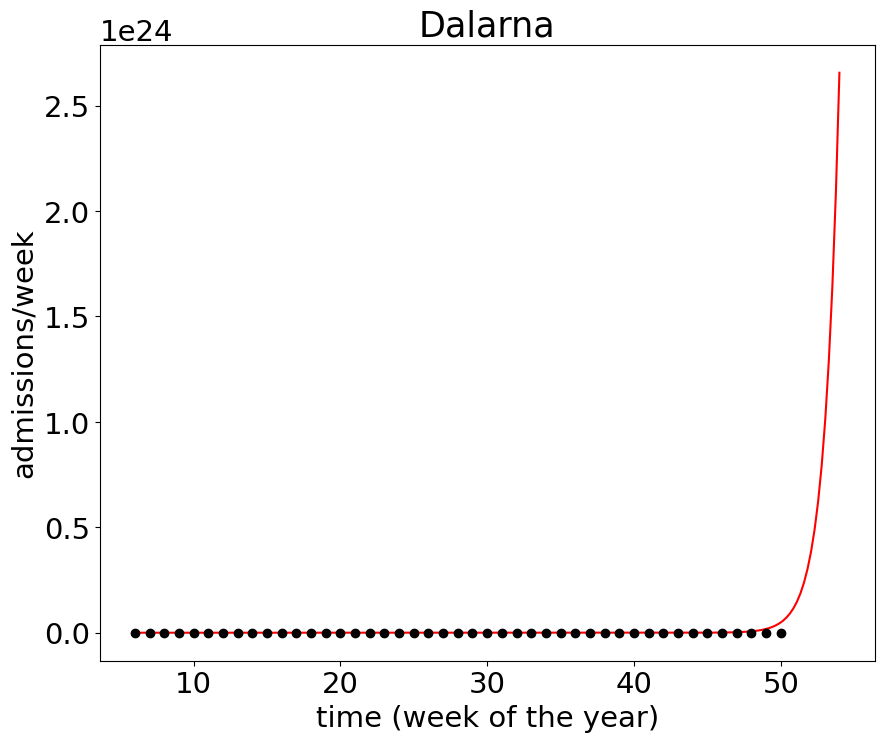

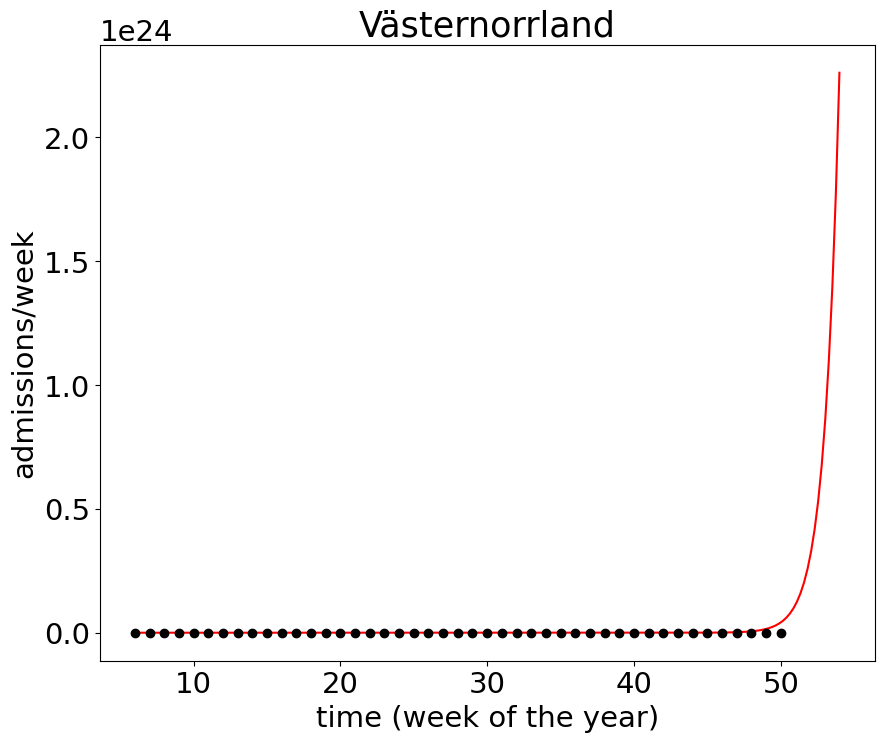

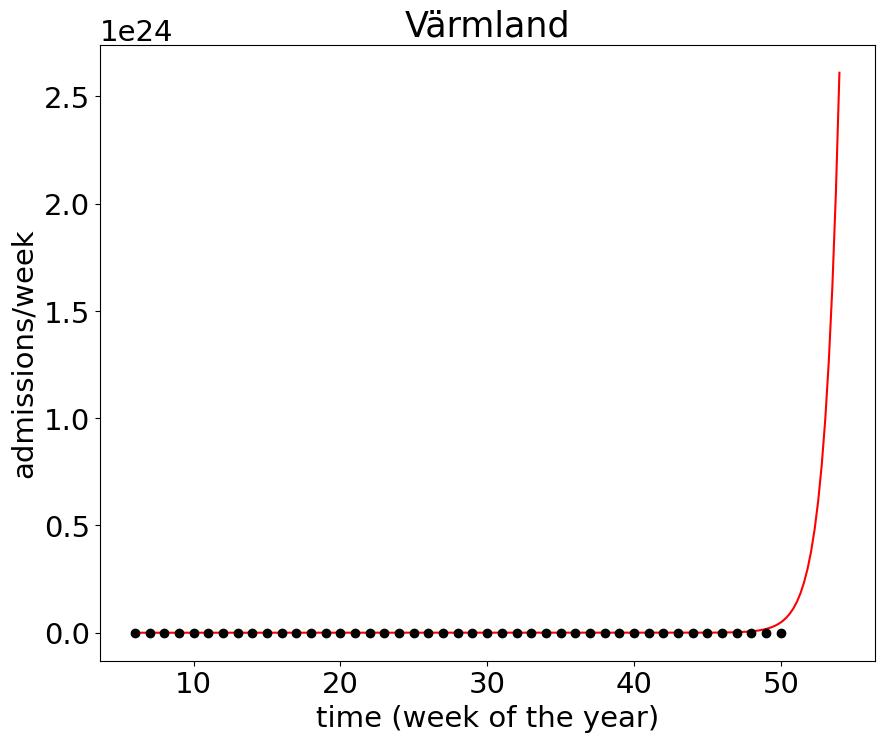

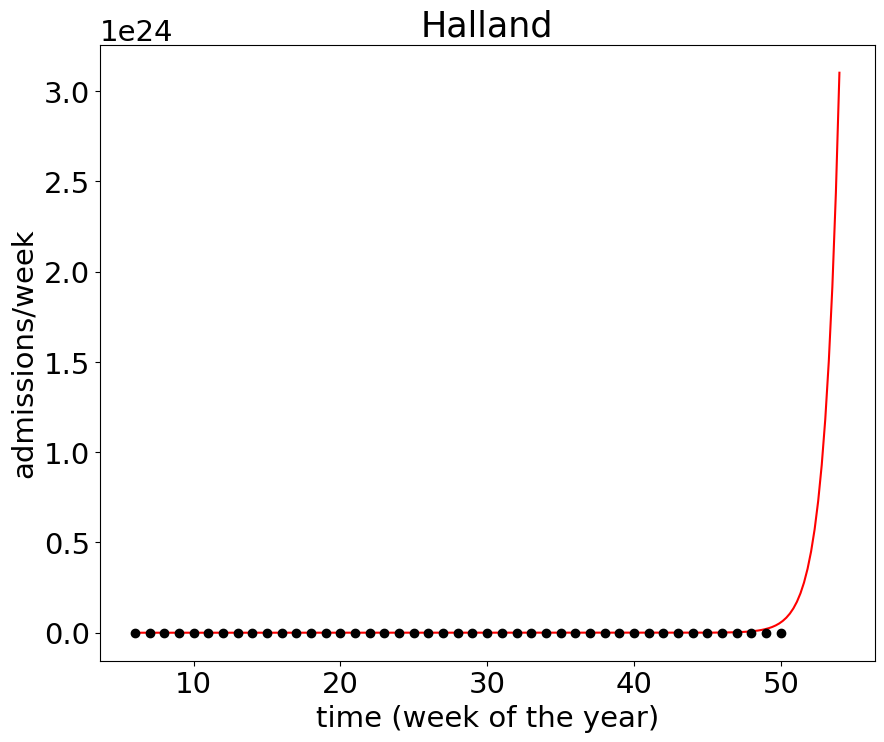

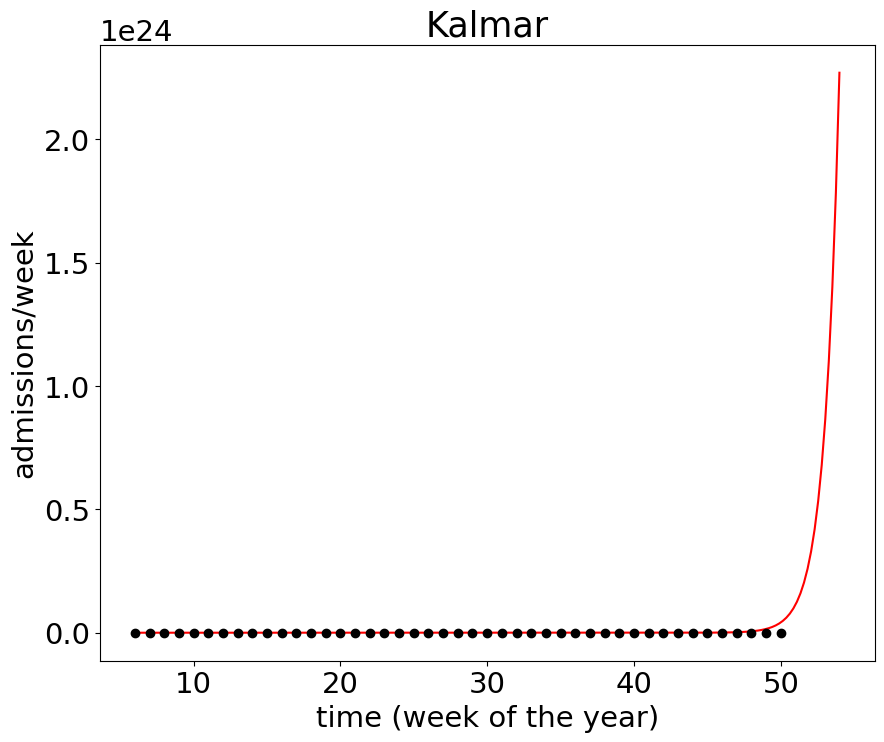

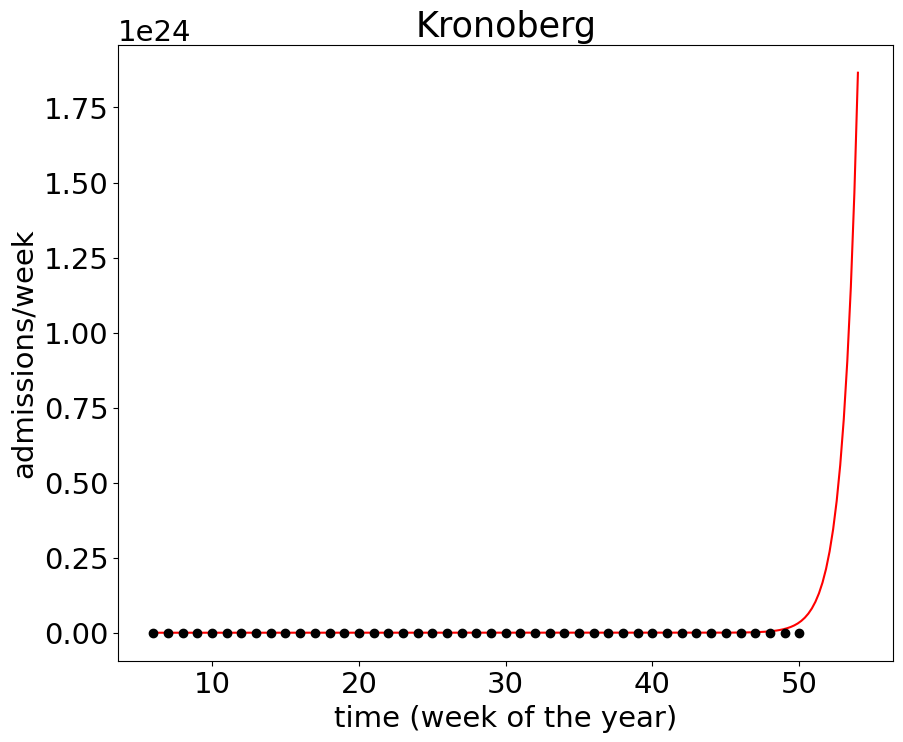

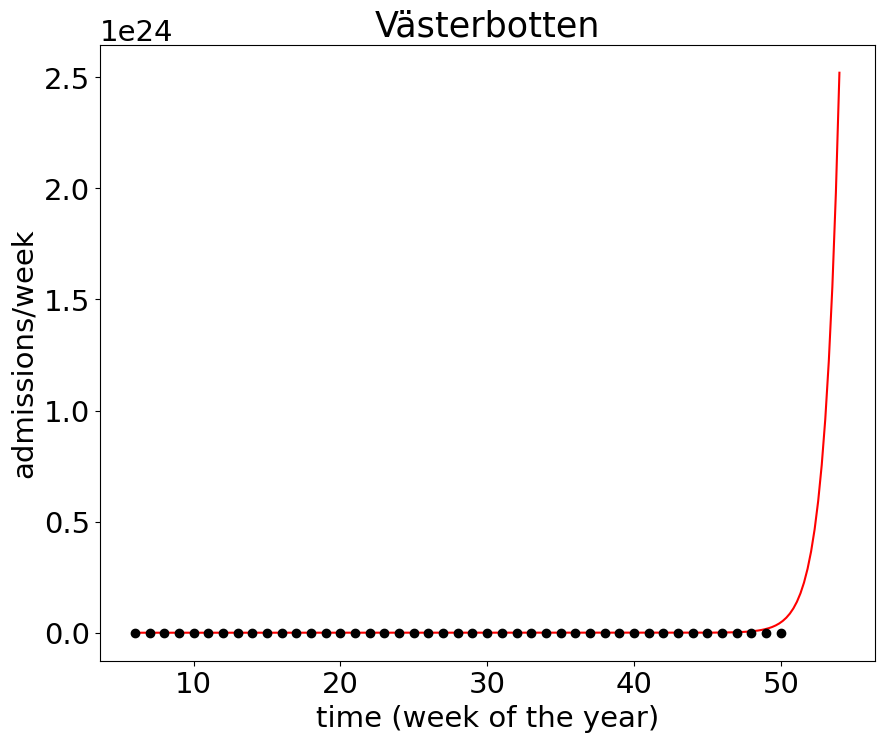

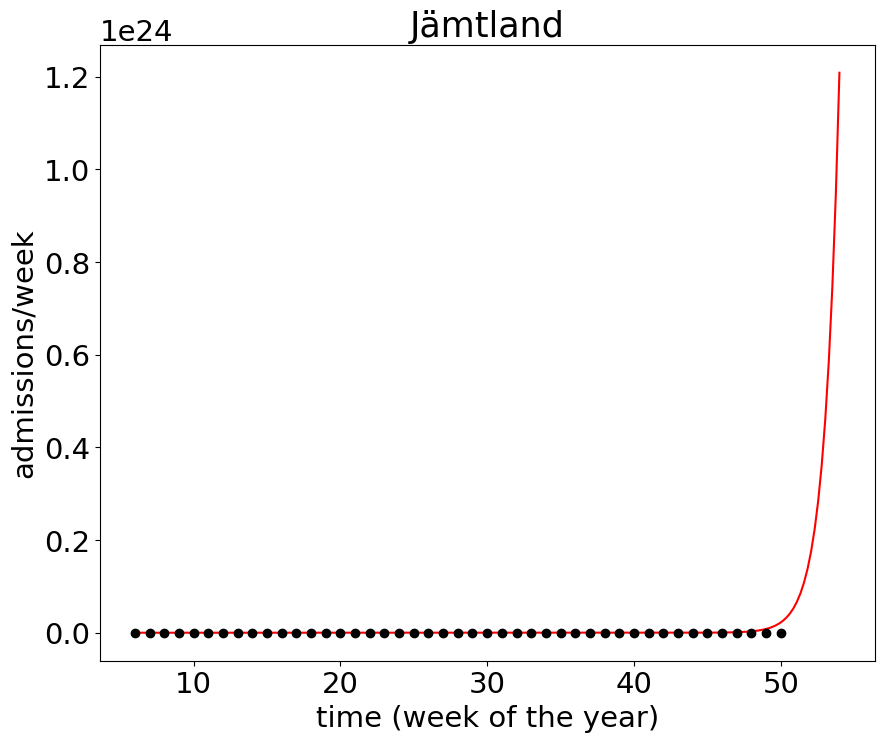

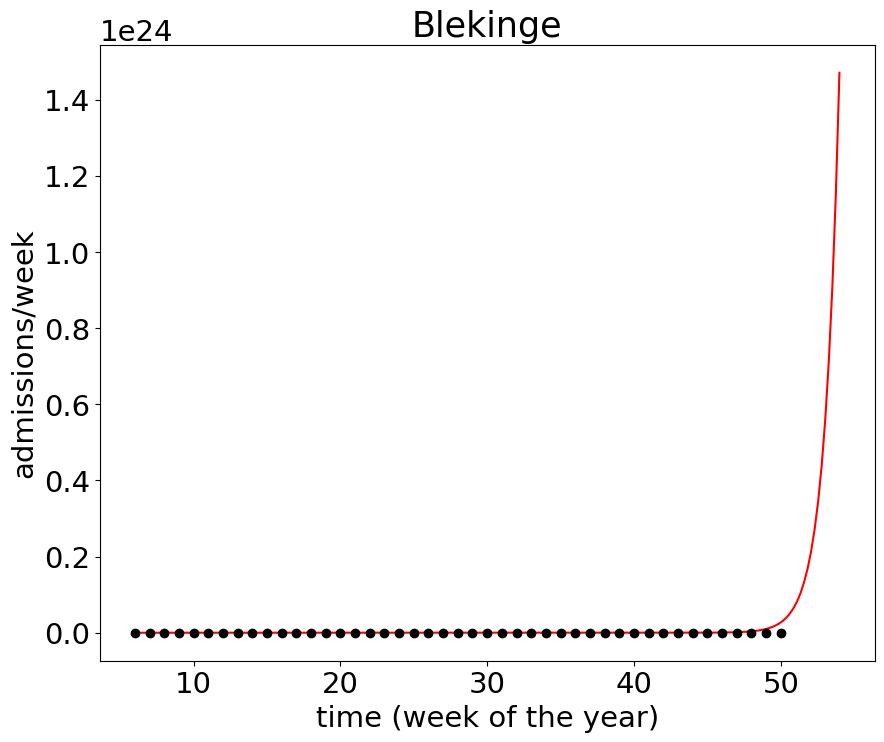

In [373]:

 


namn = regioner['region'].values
t = np.linspace(0,Tmax,200)

 #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

A=np.array([])
B=np.array([])
E=np.array([])

#Loop over regions
k=0
for R in namn:
    print(R)
    I,veckor,N = getData(R,ffall[k])
    transit_fkn=loadMobility(R,startvecka[k])
    print(astart[k],bstart[k])
    a,b,e = fitModel(veckor,I,astart[k],bstart[k],lag = delay )
    pred = pred_inlagda(t,a,b,lag = delay)
    A=np.append(A,a)
    B=np.append(B,b)
    E=np.append(E,e)
    print(a,b)
    
    #Plot and save figure
    fig, axes = plt.subplots(1,1,figsize=(10,8))
    axes.plot(t+startvecka[k],pred,'r',label="Prediktion med resor") 
    axes.plot(veckor+startvecka[k],I,'ko',label="Inlagda")
    axes.set_xlabel('time (week of the year)')
    axes.set_ylabel('admissions/week')
    axes.set_title(R)
    fig.savefig(R+".pdf",format='pdf')
    k=k+1
    
regioner['a'] = A
regioner['b'] = B
regioner['E'] = E
regioner.to_pickle('regioner.pkl')  #save results in dataframe



In [374]:
print(regioner)

            region  index  population Regionkod   Area  Första fall         a  \
0            Sthlm      8     2389923     SE-AB   6524            9  4.759494   
1              VGR      9     1725881      SE-O  23800            9  3.848101   
2            Skåne     10     1387650      SE-M  10968            9  3.620253   
3     Östergötland     11      467095      SE-E  10559            9  3.734177   
4        Jönköping     12      364750      SE-F   8190            9  3.278481   
5     Södermanland     13      299101      SE-D  10437            9  3.734177   
6          Uppsala     14      387628      SE-C   5427            9  3.506329   
7        Gävleborg     15      287660      SE-X   8504            9  3.164557   
8      Västmanland     16      277074      SE-U   6075            9  3.506329   
9           Örebro     17      305726      SE-T  28029            9  3.392405   
10      Norrbotten     18      249768     SE-BD  18118            9  3.050633   
11         Dalarna     19   

In [154]:
df = pandas.read_pickle('../data/regioner.pkl')
yta=np.array([6524,23800,10968,10559,8190,10437,5427,8504,6075,28029,18118,17519,5118,54665,97239,11165,21549,8424,2931,48935])
df['Area']=yta

df.drop('index',axis='columns', inplace=True)
df.drop('Regionkod',axis='columns', inplace=True)
df.drop('Första fall',axis='columns', inplace=True)
df = df[['region','population','Area','a','b','E']]

LinregressResult(slope=0.00011567264820966457, intercept=-7.451912318969256, rvalue=0.8661044245051898, pvalue=7.999136488528742e-07, stderr=1.573530817936148e-05, intercept_stderr=12.227325244133565)

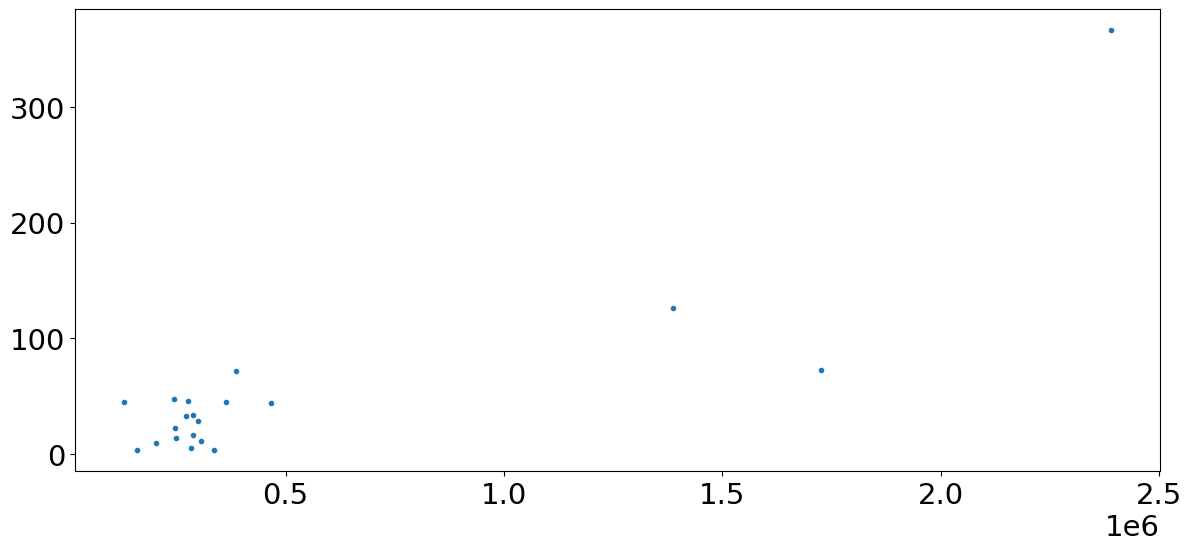

In [155]:
#Here we test correlations between error, estimated parameters and region properties
E=df['E'].values
N=df['population'].values
area=df['Area'].values
A=df['a'].values
B=df['b'].values
fig, axes = plt.subplots(1,1,figsize=(14,6))
axes.plot(N,N/area,'.')
from scipy.stats import linregress
linregress(N,N/area)

In [122]:
def dx(x, t, a, b, delay):
    S, E, I, R = x  # Unpacking the list
    # Define the differential equations
    dSdt = - (a * S * I) / N
    dEdt = (a * S * I) / N - b * E
    dIdt = b * E - gamma * I
    dRdt = gamma * I
    
    return [dSdt, dEdt, dIdt, dRdt]  # Must be a 1D list


In [123]:
x0 = [N - 1, 0, 1, 0]  # Initial conditions for SEIR


In [124]:
def dx(x, t, a, b, delay):
    S, E, I, R = x
    dSdt = - (a * S * I) / N
    dEdt = (a * S * I) / N - b * E
    dIdt = b * E - gamma * I
    dRdt = gamma * I
    dx_values = [dSdt, dEdt, dIdt, dRdt]
    print("dx values:", dx_values)
    return dx_values


In [128]:
for R in namn:
    print(R)
    I,veckor,N = getData(R,ffall[k])
    transit_fkn=loadMobility(R,startvecka[k])
    a,b,e = fitModel(veckor,I,astart[k],bstart[k])

    x = odeint(dx, x0, t, args=(a, b, delay))


Sthlm
<function pred_inlagda at 0x7ccd41351bc0> [0.0 0.0 0.0 0.0 37 83 335 734 968 984 872 739 567 548 448 394 440 364 292
 220 171 111 82 57 52 41 47 38 28 23 29 30 31 31 57 88 78 131 262 399 531
 592 632 548 521] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] (4.759493670886076, 9.215189873417721)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.